<a href="https://colab.research.google.com/github/lucacerab/emotion-detection/blob/main/GRU_emodetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotions detection in song lyrics
The goal of this notebook is to build a classifier to extract emotions from song lyrics. Done that we can check if there is correlation between song genres and emotion. Also, we can build a playlist generator based on the user mood and preferred genre.

In [ ]:
import pandas as pd
import glob
import re
import numpy as np
from tqdm import tqdm

!pip install emoji
import emoji
import spacy

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

     |████████████████████████████████| 133kB 6.3MB/s 


In [ ]:
# Labels
emotions = ['anger', 'fear', 'joy', 'sadness']
num_classes = 4

# Dimensions for word embedding
embedding_dim = 300

# Max input length (# words) 
max_seq_len = 500

trunc_type = 'post'
padding_type = 'post'

training_portion = 0.9

seed = 123

In [ ]:
# Import data
train_df = pd.concat([pd.read_csv(f, delimiter = "\t", names=['id', 'text', 'sentiment', 'intensity']) for f in glob.glob('*train.txt')], ignore_index = True)
test_df = pd.concat([pd.read_csv(f, delimiter = "\t", names=['id', 'text', 'sentiment', 'intensity']) for f in glob.glob('*test*.txt')], ignore_index = True)

In [ ]:
train_df.head()

,id,text,sentiment,intensity
0,20000,I feel like I am drowning. #depression #anxiet...,fear,0.979
1,20001,I get so nervous even thinking about talking t...,fear,0.979
2,20002,I lost my blinders .... #panic,fear,0.975
3,20003,I feel like I am drowning. #depression #falur...,fear,0.938
4,20004,This is the scariest American Horror Story out...,fear,0.938


fear       1147
anger       857
joy         823
sadness     786
Name: sentiment, dtype: int64




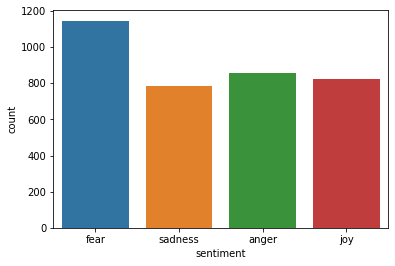

In [ ]:
print(train_df.sentiment.value_counts())
print('\n')

sns.countplot(x = train_df.sentiment)
plt.show()

In [ ]:
train_df.isna().sum()
test_df.isna().sum()

id           0
text         0
sentiment    0
intensity    0
dtype: int64

In [ ]:
# Get train data from train_df 
trainData = [i for i in tqdm(train_df.text)]
trainLabels = [i for i in tqdm(train_df.sentiment)]

# Get test data from test_df
testData = [i for i in tqdm(test_df.text)]
testLabels = [i for i in tqdm(test_df.sentiment)]

100%|██████████| 3142/3142 [00:00<00:00, 373974.95it/s]


In [ ]:
# Shuffle training data
rng = np.random.RandomState(seed)
rng.shuffle(trainData)
rng = np.random.RandomState(seed)
rng.shuffle(trainLabels)

# Shuffle test data
rng = np.random.RandomState(seed)
rng.shuffle(testData)
rng = np.random.RandomState(seed)
rng.shuffle(testLabels)

In [ ]:
# Function to clean tweets
def give_emoji_free_text(text): 
    return emoji.get_emoji_regexp().sub(r'', text)

emoticon_string = r"""(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)"""

def clean(string):
    # remove graphical emoji
    string = give_emoji_free_text(string) 

    # remove textual emoji
    string = re.sub(emoticon_string, '', string)

    # remove old style retweet text "RT"
    string = re.sub(r'^RT[\s]+', '', string)

    # remove hyperlinks
    string = re.sub(r'https?:\/\/.*[\r\n]*', '', string)

    # remove user (@user)
    string = re.sub(r"""(?:@[\w_]+)""",'',string)

    # remove # and keep text
    string = re.sub(r'#', '', string)

    # removing stop words 
    #string = ' '.join([w for w in string.split() if w not in stopwords])

    # removing \\n and extra spaces
    string = re.sub(r'\\n', '', string)
    string = string.strip()
    string = re.sub(' +', ' ', string)

    return string

In [ ]:
# Cleaning tweets 
trainTweets = [clean(text) for text in tqdm(trainData)]
testTweets = [clean(text) for text in tqdm(testData)]

tweets = trainTweets + testTweets

100%|██████████| 3142/3142 [00:01<00:00, 2046.95it/s]


In [ ]:
# Transforming data so that the model can accept them
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets) 

word_index = tokenizer.word_index
vocab_size = len(word_index)

train_sequences = tokenizer.texts_to_sequences(trainTweets)
train_pad = pad_sequences(train_sequences, maxlen=max_seq_len, padding=padding_type, truncating=trunc_type)

xTest = tokenizer.texts_to_sequences(testTweets)
xTest_pad = pad_sequences(xTest, maxlen=max_seq_len, padding=padding_type, truncating=trunc_type)

In [ ]:
# Split traininig data in train and validation 
train_size = int(len(trainTweets) * training_portion)

xTrain_pad = train_pad[:train_size]
train_labels = trainLabels[:train_size]

xVal_pad = train_pad[train_size:]
val_labels = trainLabels[train_size:]

In [ ]:
# One-hot encoding labels
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
yTrain = lb.fit_transform(train_labels) # fit_transform finds all unique class labels and transform them in one-hot encoded labels
yVal = lb.transform(val_labels) # transform performs one-hot encoding based on classes already found in .fit
yTest = lb.transform(testLabels) 

print("train labels shape:", yTrain.shape)
print("val labels shape:", yVal.shape)
print("test labels shape:", yTest.shape)

train labels shape: (3251, 4)
val labels shape: (362, 4)
test labels shape: (3142, 4)


In [ ]:
# Download GloVe pre-trained word vectors
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip && rm glove.6B.zip

--2021-04-29 07:10:29--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.07MB/s    in 2m 40s  

2021-04-29 07:13:09 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
# Dict mapping words to their vector representation
embeddings_index = {}
with open('/content/glove.6B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

# Embedding matrix
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(embeddings_matrix.shape)

(12852, 300)


In [ ]:
# Model selection
units = 128
gru = True

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_seq_len, weights=[embeddings_matrix], trainable=False))

if gru:
    model.add(Bidirectional(GRU(units=units, dropout=0.2, recurrent_dropout=0.2)))
else:
     model.add(Bidirectional(LSTM(units=units, dropout=0.2, recurrent_dropout=0.2)))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          3855600   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
Total params: 4,186,868
Trainable params: 331,268
Non-trainable params: 3,855,600
_________________________________________________________________


In [ ]:
batch_size = 128
epochs = 10

hist = model.fit(xTrain_pad, yTrain, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(xVal_pad, yVal))

Epoch 1/10
26/26 [==============================] - 72s 3s/step - loss: 1.3771 - accuracy: 0.3161 - val_loss: 1.2966 - val_accuracy: 0.4006
Epoch 2/10
26/26 [==============================] - 65s 3s/step - loss: 1.2583 - accuracy: 0.4345 - val_loss: 1.1542 - val_accuracy: 0.4724
Epoch 3/10
26/26 [==============================] - 66s 3s/step - loss: 1.0594 - accuracy: 0.5518 - val_loss: 0.9194 - val_accuracy: 0.5994
Epoch 4/10
26/26 [==============================] - 67s 3s/step - loss: 0.8359 - accuracy: 0.6718 - val_loss: 0.7643 - val_accuracy: 0.7044
Epoch 5/10
26/26 [==============================] - 64s 2s/step - loss: 0.6203 - accuracy: 0.7626 - val_loss: 0.6714 - val_accuracy: 0.7293
Epoch 6/10
26/26 [==============================] - 66s 3s/step - loss: 0.5645 - accuracy: 0.7988 - val_loss: 0.5955 - val_accuracy: 0.7928
Epoch 7/10
26/26 [==============================] - 66s 3s/step - loss: 0.4550 - accuracy: 0.8434 - val_loss: 0.5701 - val_accuracy: 0.7901
Epoch 8/10
26/26 [==

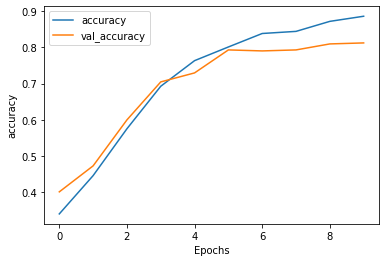

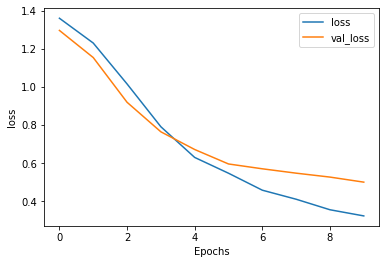

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(hist, "accuracy")
plot_graphs(hist, "loss")

In [ ]:
# Make predictions on test set
Y_pred = model.predict(xTest_pad)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(yTest, axis=1)

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_true, y_pred) * 100))

Accuracy: 80.52%


In [ ]:
# https://scikit-learn.org/0.20/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

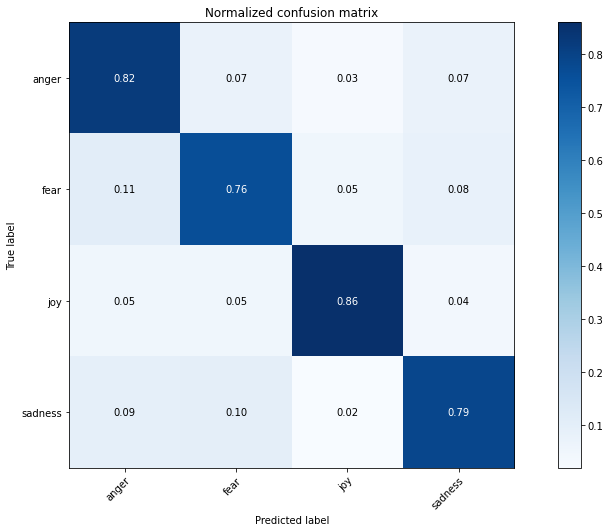

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=emotions, normalize=True, title='Normalized confusion matrix')
plt.show()

Let's use the model to predict emotions from song lyrics

In [ ]:
songs = pd.read_csv('/content/lyrics.csv', encoding='utf8').dropna()
songs.head()

,rank,song,artist,genre,lyrics
0,1,Blinding Lights,The Weeknd,Synthwave,Yeah\n\nI've been tryna call\nI've been on my ...
1,2,Circles,Post Malone,Pop rock,"Oh, oh, oh\nOh, oh, oh\nOh, oh, oh, oh, oh\n..."
2,3,The Box,Roddy Ricch,Hip hop,Pullin' out the coupe at the lot\nTold 'em fuc...
3,4,Don't Start Now,Dua Lipa,Nu-disco,If you don't wanna see me\n\nDid a full one-ei...
4,5,Rockstar,DaBaby,Hip hop music,"Woo, woo\nI pull up like\nHow you pull up, Bab..."


In [ ]:
# Get song lyrics
rawLyrics = []
for lyrics in songs.lyrics:
  lyrics = re.sub('\n', ' ', lyrics)
  rawLyrics.append(lyrics)

lyrics = []
for l in rawLyrics:
  lyric = (l.encode('ascii', 'ignore')).decode("utf-8")
  lyric = re.sub('\'', ' ', lyric)
  lyrics.append(lyric)

In [ ]:
# Make predictions
preds = []
for l in lyrics:
  seq = tokenizer.texts_to_sequences([l])
  padded = pad_sequences(seq, maxlen=max_seq_len, padding=padding_type, truncating=trunc_type)

  pred = model.predict(padded)
  prediction = lb.inverse_transform(pred)
  for p in prediction:
    preds.append(p)

In [ ]:
songs['emotion'] = preds
songs.head()

,rank,song,artist,genre,lyrics,emotion
0,1,Blinding Lights,The Weeknd,Synthwave,Yeah\n\nI've been tryna call\nI've been on my ...,anger
1,2,Circles,Post Malone,Pop rock,"Oh, oh, oh\nOh, oh, oh\nOh, oh, oh, oh, oh\n...",anger
2,3,The Box,Roddy Ricch,Hip hop,Pullin' out the coupe at the lot\nTold 'em fuc...,anger
3,4,Don't Start Now,Dua Lipa,Nu-disco,If you don't wanna see me\n\nDid a full one-ei...,anger
4,5,Rockstar,DaBaby,Hip hop music,"Woo, woo\nI pull up like\nHow you pull up, Bab...",anger


Are emotions correlated to song genres?

In [ ]:
dic = {'hiphop': 'Hip hop,Hip hop music,Trap music,Pop rap,Pop-rap,West Coast hip hop,Trap music (hip hop),Lo-fi hip hop,Trap Music,Emo rap,Political hip hop,Drill music,Bounce music',
       'rock': 'Soft rock,Pop rock',
       'rnb': 'Contemporary R&B,Funk',
       'pop': 'Pop music,Latin pop,Soft pop,Christmas music',
       'dance': 'Synthwave,Nu-disco,Disco,Electro (music),Chillwave,Electropop,Dance-pop',
       'country': 'Country music,Country pop',
       'acoustic': 'Acoustic music',
       'reggae': 'Dancehall,Reggae fusion'}

d = {k: oldKey for oldKey, oldValue in dic.items() for k in oldValue.split(',')}

songs['general_genre'] = songs['genre'].map(d)
songs.head()

,rank,song,artist,genre,lyrics,emotion,general_genre
0,1,Blinding Lights,The Weeknd,Synthwave,Yeah\n\nI've been tryna call\nI've been on my ...,anger,dance
1,2,Circles,Post Malone,Pop rock,"Oh, oh, oh\nOh, oh, oh\nOh, oh, oh, oh, oh\n...",anger,rock
2,3,The Box,Roddy Ricch,Hip hop,Pullin' out the coupe at the lot\nTold 'em fuc...,anger,hiphop
3,4,Don't Start Now,Dua Lipa,Nu-disco,If you don't wanna see me\n\nDid a full one-ei...,anger,dance
4,5,Rockstar,DaBaby,Hip hop music,"Woo, woo\nI pull up like\nHow you pull up, Bab...",anger,hiphop


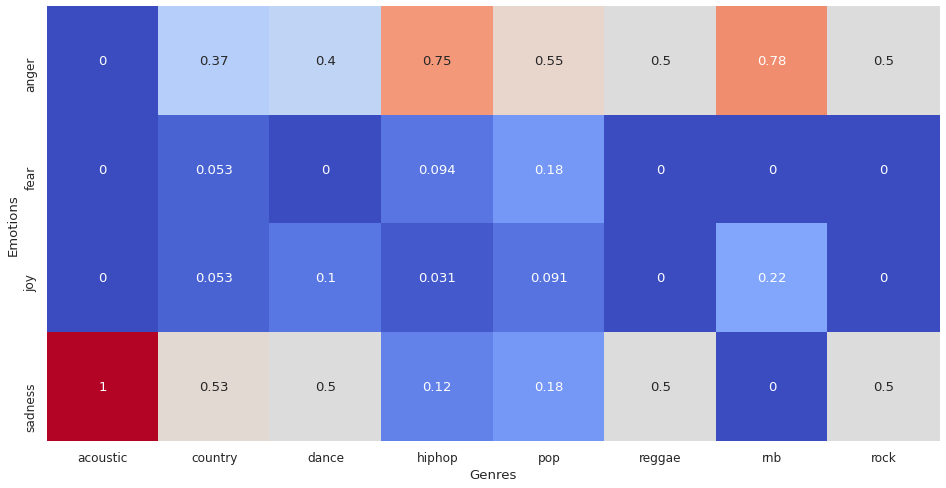

In [ ]:
# Correlation matrix between emotions and music genres
corr_df = pd.crosstab(songs.emotion, songs.general_genre, rownames=['Emotions'], colnames=['Genres'], normalize='columns')

plt.figure(figsize=(16, 8))
sns.set(font_scale=1.1)
sns.heatmap(corr_df, annot = True, cmap= 'coolwarm', cbar=False);

Playlist generator based on user's mood and genre preferences

In [ ]:
# Playlist generator 
prefGenre = input("What genre you'd like to listen to? ")
mood = input("What's your mood? ") 
print('\n')

playDF = songs[(songs['general_genre'] == prefGenre) & (songs['emotion'] == mood)]

play = {}
for index, row in playDF.iterrows():
  play[row['song']] = row['artist']

print('Go listen these songs:')
for k,v in play.items():
  print(k + ' - ' + v)

What genre you'd like to listen to? hiphop
What's your mood? sadness


Go listen these songs:
Toosie Slide - Drake 
Death Bed - Powfu
Heart on Ice - Rod Wave
Suicidal - YNW Melly
